In [1]:
from PIL import Image
import numpy as np
import cv2

# path to the image
path = "part2-image1.jpg"

# Load image
img = Image.open(path)

# Convert image to grayscale
img = img.convert("L")

# Normalize image
img = np.array(img) / 255.0

# Flatten image
img = img.flatten()

# Convert to 2D array
images = img[None, :]

import numpy as np
import networkx as nx

# Assume images is a 2D array with each row being a flattened image

# Step 1: Compute the Euclidean distance matrix
dist_matrix = np.sqrt(np.sum((images[:, None] - images) ** 2, axis=-1))

# Step 2: Construct a k-nearest neighbors graph
k = 5  # number of neighbors
neighbors = np.argsort(dist_matrix, axis=1)[:, 1 : k + 1]
graph = nx.from_numpy_array(dist_matrix)
graph.remove_edges_from(graph.edges)
for i in range(images.shape[0]):
    for j in neighbors[i]:
        graph.add_edge(i, j, weight=dist_matrix[i, j])

# Step 3: Compute the shortest path distance matrix
shortest_path_dist_matrix = np.array(nx.floyd_warshall_numpy(graph))

# Step 4: Apply classical MDS
# First, compute the centering matrix
H = (
    np.eye(images.shape[0])
    - np.ones((images.shape[0], images.shape[0])) / images.shape[0]
)

# Then, compute the Gram matrix
B = -H @ (shortest_path_dist_matrix**2) @ H / 2

# Finally, compute the eigenvalues and eigenvectors of B
eigvals, eigvecs = np.linalg.eigh(B)

# The lower-dimensional embedding is given by the top k eigenvectors scaled by the square root of the corresponding eigenvalues
n_components = 1000  # number of dimensions in the lower-dimensional space
idx = np.argsort(eigvals)[::-1][:n_components]
compressed_images = eigvecs[:, idx] @ np.diag(np.sqrt(eigvals[idx]))

cv2.imwrite("isomap.jpg", compressed_images)


def knn_predict(X_train, y_train, X_test, k):
    # Compute the Euclidean distance between each test point and all training points
    dists = np.sqrt(np.sum((X_test[:, None] - X_train) ** 2, axis=-1))

    # Find the k nearest neighbors
    neighbors = np.argsort(dists, axis=1)[:, :k]

    # Compute the mean of the neighbors
    return np.mean(y_train[neighbors], axis=1)


# Use the KNN regressor to decompress the images
decompressed_images = knn_predict(compressed_images, images, compressed_images, k=5)

# Reshape the first decompressed image to the original image shape
image_height, image_width = (
    1280,
    900,
)  # replace with the height and width of your original image
decompressed_image = decompressed_images[0].reshape(image_height, image_width)

# Save the decompressed image
decompressed_image = Image.fromarray((decompressed_image * 255).astype(np.uint8))
decompressed_image.save("decompressed_image.jpg")

In [3]:
import os
import math
import numpy as np
import cv2

# Calculate the size of the original and compressed images in bytes
def metric(input_path, output_path):
    original_size = os.path.getsize(input_path)
    compressed_size = os.path.getsize(output_path)

    # Calculate the compression ratio
    compression_ratio = original_size / compressed_size
    print(f"Compression Ratio: {compression_ratio}")

    # Load the original and decompressed part2-image1s
    original = cv2.imread(input_path)
    decompressed = cv2.imread(output_path)

    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original - decompressed) ** 2)

    # Calculate the PSNR
    if mse == 0:
        psnr = math.inf
    else:
        max_pixel = 255.0
        psnr = 20 * math.log10(max_pixel / math.sqrt(mse))

    print(f"PSNR: {psnr}")

In [5]:
import numpy as np
from PIL import Image
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh


def isomap(D, n_components):
    # Compute the squared distance matrix
    S = squareform(D**2)

    # Compute the centering matrix
    H = np.eye(S.shape[0]) - np.ones(S.shape) / S.shape[0]

    # Apply the centering matrix to the squared distance matrix
    B = -H @ S @ H / 2

    # Compute the eigenvalues and eigenvectors of B
    evals, evecs = eigh(B)

    # Sort the eigenvalues and eigenvectors in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Select the first n_components eigenvectors
    evecs = evecs[:, :n_components]

    # Compute the corresponding eigenvalues
    evals = evals[:n_components]

    # Compute the final embedding
    Y = evecs * np.sqrt(np.maximum(evals, 0))

    return Y


def compress_image(image_path, output_path):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    image = image.convert("L")

    # Convert the image to a NumPy array
    X = np.array(image)
    flag = 0
    if X.shape[0] < X.shape[1]:
        flag = 1
        X = X.T
    n_components = X.shape[1]

    # Compute the pairwise distances
    D = pdist(X)

    # Apply Isomap
    Y = isomap(D, n_components)

    # Normalize the result to the range 0-255
    Y = (Y - Y.min()) / (Y.max() - Y.min()) * 255

    # Convert the result to 8-bit integer format
    Y = np.maximum(Y, 0).astype(np.uint8)

    # Reshape the result into an image
    if flag:
        Y = Y.T
    compressed_image = Image.fromarray(Y)

    # Save the image
    compressed_image.save(output_path, "JPEG")
    metric(image_path, output_path)

    return compressed_image


path = "part2-image1.jpg"


compressed_images = compress_image(path, "output.jpg")



Compression Ratio: 13.05483476132191
PSNR: 27.97176626253828


MemoryError: Unable to allocate 54.9 GiB for an array with shape (1280, 5, 1152000) and data type float64

In [22]:
f = Image.open("part2-image2.jpeg")
f = np.array(f)
f.shape[:2]

(1080, 1920, 3)

In [20]:
def decompress_image(compressed_path, output_path, original_shape):
    # Load the compressed image
    compressed_image = Image.open(compressed_path)

    # Convert the compressed image to a NumPy array
    Y = np.array(compressed_image)

    # Reshape the array to match the original image dimensions
    Y = Y.reshape(original_shape)

    # Convert back to the original scale
    Y = (Y / 255.0) * (Y.max() - Y.min()) + Y.min()

    # Apply the inverse Isomap transformation (you may need to implement this)
    # Inverse Isomap transformation is not provided in the code; you need to implement it.

    # Convert the result to 8-bit integer format
    Y = np.maximum(Y, 0).astype(np.uint8)

    # Reshape the result into an image
    decompressed_image = Image.fromarray(Y)

    # Save the decompressed image
    decompressed_image.save(output_path, "JPEG")

    return decompressed_image

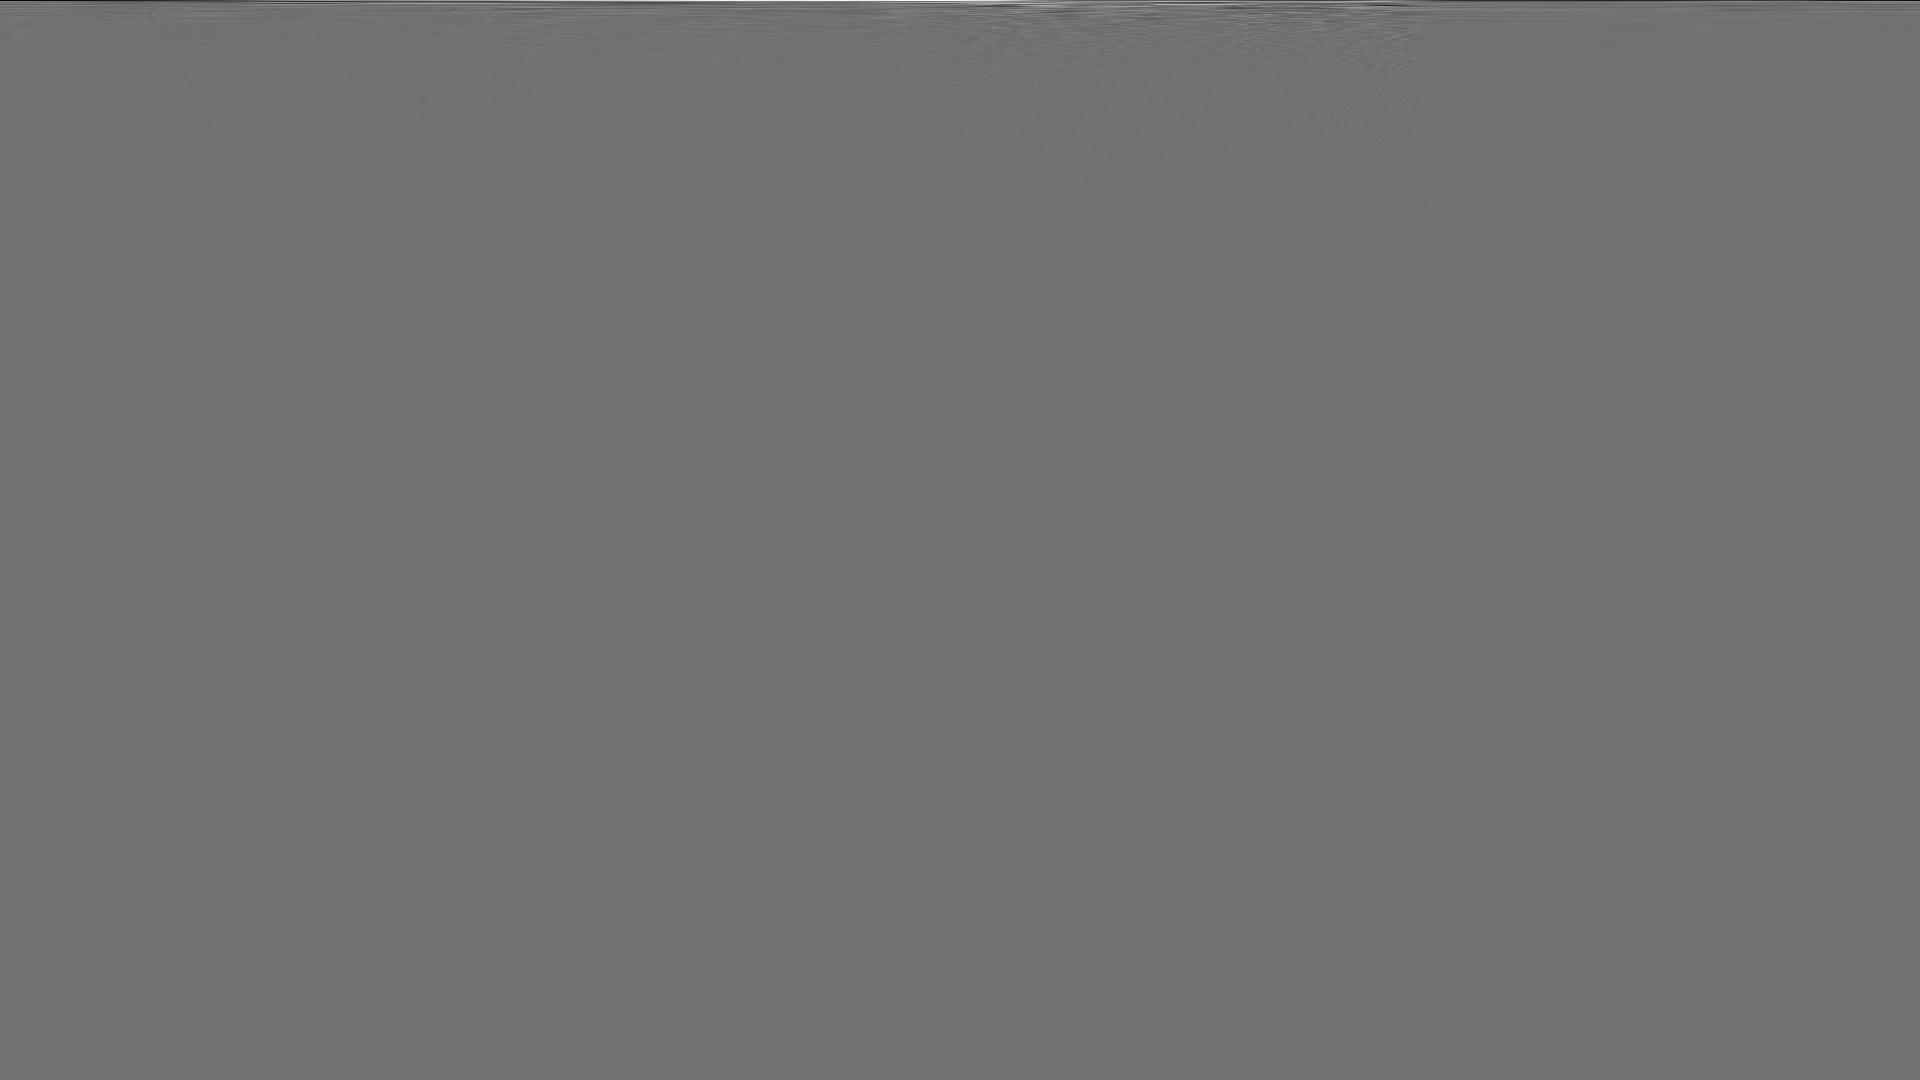

In [24]:
decompress_image("output.jpg", "decompressed_image.jpg", f.shape[:2])

In [25]:
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image

# Load your image
image = Image.open("part2-image1.jpg")
image = np.array(image)

# Reshape the image to a 2D array
pixels = image.reshape(-1, 3)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
pixels_tsne = tsne.fit_transform(pixels)

KeyboardInterrupt: 

In [27]:
from sklearn.decomposition import NMF
import numpy as np
from PIL import Image

# Load your image
image = Image.open("part2-image1.jpg")
image = np.array(image)

# Reshape the image to a 2D array
pixels = image.reshape(-1, 3)

# Perform NMF
model = NMF(n_components=50, init="random", random_state=0)
W = model.fit_transform(pixels)
H = model.components_

# Now W and H are the compressed representation of the image
# To reconstruct the image
reconstructed_pixels = np.dot(W, H)
reconstructed_image = reconstructed_pixels.reshape(image.shape)

# Save the reconstructed image
reconstructed_image = Image.fromarray(reconstructed_image.astype(np.uint8))
reconstructed_image.save("reconstructed_image.png")

KeyboardInterrupt: 

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv("/home/shusrith/benefits.csv")
df.replace(np.nan, 0, inplace=True)
df

,format,sum assured,bonus,fab,maturity
0,35 years,0,0,0,0.0
1,agent,"5,00,000","7,87,500","11,50,000",0.0
2,lic,"5,00,000","7,01,250","12,45,000",0.0
3,30 years,0,0,0,0.0
4,agent,"5,00,000",0,"17,25,000",0.0
5,lic,"5,00,000","6,72,500","10,70,000",0.0
6,25 years,0,0,0,0.0
7,agent,"5,00,000",0,"12,87,500",0.0
8,lic,"5,00,000","6,43,750","9,25,000",0.0
9,20 years,0,0,0,0.0


In [6]:
df["maturity"] = df["sum assured"].astype(int) + df["bonus"].astype(int) + df["fab"].astype(int)
df

ValueError: invalid literal for int() with base 10: '5,00,000'